# Extreme Gradient Boosting 
(for PM 2.5)

In [1]:
!pip install xgboost


 Training Model for Chicago 
 Best Hyperparameters for Chicago: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300, 'reg_alpha': 0.01, 'reg_lambda': 50, 'subsample': 0.8}
 Chicago Model Performance:
   • Mean Absolute Error (MAE): 1.6888
   • Mean Squared Error (MSE): 5.9634
   • R-squared Score (R²): 0.9034


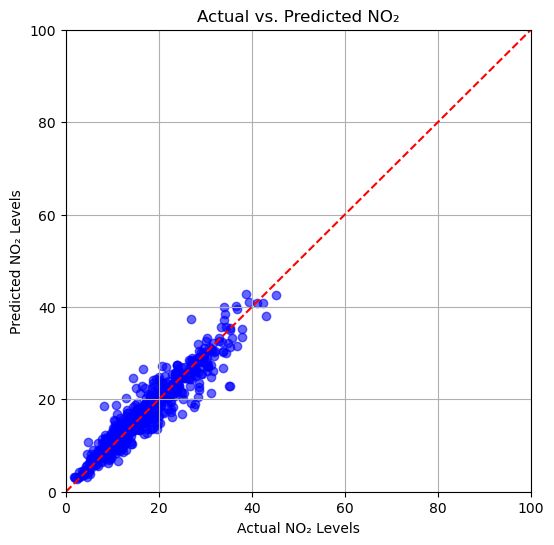


 Training Model for Los Angeles 
 Best Hyperparameters for Los Angeles: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 500, 'reg_alpha': 0.1, 'reg_lambda': 10, 'subsample': 0.8}
 Los Angeles Model Performance:
   • Mean Absolute Error (MAE): 2.2731
   • Mean Squared Error (MSE): 11.1659
   • R-squared Score (R²): 0.9151


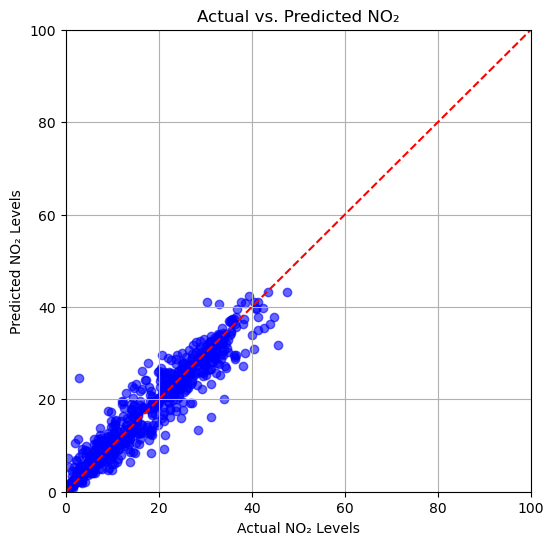

In [2]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import warnings
import matplotlib.pyplot as plt

# Suppress warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("updated_air_quality_dataset.csv")

#  Fix column names to remove whitespace
df.columns = df.columns.str.replace(" ", "_")

#  Map County Names to City Names
county_to_city = {
    "Cook": "Chicago",
    "New York": "New York",
    "Los Angeles": "Los Angeles"
}
df["City"] = df["County_Name"].map(county_to_city)

#  Feature Engineering - Convert 'Day' to Cyclic Encoding
df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 7)
df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 7)

#  Feature Engineering - Rolling Average for PM2.5 (3-hour trend)
df["NO2_Rolling_Avg"] = df["NO2"].rolling(window=3, min_periods=1).mean()

# Define updated features
features = [
    'temperature_2m_(°C)', 'relative_humidity_2m_(%)', 
    'precipitation_(mm)', 'wind_speed_100m_(km/h)',
    'Day_sin', 'Day_cos', 'NO2_Rolling_Avg', 'Hour'
]
target = 'NO2'

# Drop rows with missing values in features
df = df.dropna(subset=features)

results= pd.DataFrame(columns=["City","Actual Values", "Predicted Values"])
#  Train a model for each city
for city in ["Chicago", "Los Angeles"]:
    print(f"\n Training Model for {city} ")
    
    # Filter data for the specific city
    city_df = df[df["City"] == city]
    
    # Check if there's enough data
    if city_df.shape[0] < 50:
        print(f" Not enough data for {city}. Skipping...")
        continue
    
    # Extract features and target
    X = city_df[features]
    y = city_df[target]

    # Standardizing features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Splits Data into Training (80%) and Testing (20%)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Define parameter grid for Grid Search
    param_grid = {
        'n_estimators': [300, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [6, 8],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'reg_alpha': [0.01, 0.1],  # L1 Regularization
        'reg_lambda': [1, 10, 50]  # L2 Regularization
    }

    # Initialize XGBoost model
    xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

    # Perform Grid Search CV
    tuner = GridSearchCV(
        xgb_regressor, param_grid, scoring='r2', cv=3, verbose=0, n_jobs=-1
    )

    tuner.fit(X_train, y_train)

    # Best parameters
    best_params = tuner.best_params_
    print(f" Best Hyperparameters for {city}: {best_params}")

    # Train model with best parameters found through grid search
    xgb_best = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
    xgb_best.fit(X_train, y_train)

    # Make predictions
    y_pred = xgb_best.predict(X_test)

    new_data= pd.DataFrame({
    "City": [city]* len(y_test),
    "Actual Values": y_test,
    "Predicted Values": y_pred
    })
    results = pd.concat([results, new_data], ignore_index=True)

    # Evaluate model performance
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f" {city} Model Performance:")
    print(f"   • Mean Absolute Error (MAE): {mae:.4f}")
    print(f"   • Mean Squared Error (MSE): {mse:.4f}")
    print(f"   • R-squared Score (R²): {r2:.4f}")

    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
    plt.plot([0, 100], [0, 100], color='red', linestyle='--')
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    # Labels and legend
    plt.xlabel(u"Actual NO\u2082 Levels")
    plt.ylabel(u"Predicted NO\u2082 Levels")
    plt.title(u"Actual vs. Predicted NO\u2082")
    plt.grid(True)
    plt.show()


In [11]:
results["Pollutant"]=target
results

,City,Actual Values,Predicted Values,Pollutant
0,Chicago,17.1,18.871025,NO2
1,Chicago,18.8,20.099012,NO2
2,Chicago,11.8,12.677802,NO2
3,Chicago,8.6,8.784425,NO2
4,Chicago,11.2,12.057072,NO2
...,...,...,...,...
1483,Los Angeles,9.2,8.321300,NO2
1484,Los Angeles,15.0,10.551008,NO2
1485,Los Angeles,24.4,23.411884,NO2
1486,Los Angeles,6.2,5.606496,NO2


In [13]:
results.to_csv("xg_boost_no2.csv", index=False)

In [14]:
print(u"Actual NO\u2082 Values")

Actual NO₂ Values
